In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

tmpfiles = '/content/tmp/'
train_tmp_folder = tmpfiles+'train_embeddinds/'
test_tmp_folder = tmpfiles+'test_embeddinds/'
val_tmp_folder = tmpfiles+'val_embeddinds/'

import os.path
from os import path

if path.exists(tmpfiles) == False:

  os.mkdir(tmpfiles)
  os.mkdir(train_tmp_folder )
  os.mkdir(test_tmp_folder )
  os.mkdir(val_tmp_folder )
else:
  if path.exists(train_tmp_folder) == False or path.exists(test_tmp_folder) == False or path.exists(val_tmp_folder) == False:
    try:
      os.mkdir(train_tmp_folder )
      os.mkdir(test_tmp_folder )
      os.mkdir(val_tmp_folder )
    except Exception:
      pass

!ls

#%cd /content/gdrive/MyDrive/ThermostabilityProject/
!pip install transformers tqdm
%cd /content/gdrive/MyDrive/ThermostabilityProject/


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
gdrive	sample_data  tmp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/gdrive/.shortcut-targets-by-id/128ufe3PZnTSA0vqnqfO39qUHekWbH816/ThermostabilityProject


In [2]:
!ls

datasets				 prepro_embeddings     ref_models
drive-download-20230426T195016Z-001.zip  ProtBERT_repro.ipynb  train_tmp_folder
filename_pi.pth				 README.md


In [3]:
!pip install bettertransformers optimum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import torch, torch.nn
from transformers import BertModel, BertTokenizer, pipeline
import re, gc, os
import requests
from tqdm.auto import tqdm

In [12]:
def train_test_validation_splits(df):
    test,train_tot = df.loc[df['set']=='test'],df.loc[df['set']=='train']
    train, val = train_tot.loc[train_tot['validation']!=True], train_tot.loc[train_tot['validation']==True]
    return train,val, test

def build_batch_iterator_sequences(sequences_total, batch_size):

    long_list = sequences_total
    sub_list_length = batch_size
    sub_lists = [
        long_list[i : i + sub_list_length]
        for i in range(0, len(long_list), sub_list_length)
    ]
    return sub_lists

def get_features_from_embeddings(embeddings, attention_mask):
    features = [] 
    for seq_num in range(len(embeddings)):
          seq_len = (attention_mask[seq_num] == 1).sum()
          seq_emd = embeddings[seq_num][1:seq_len-1]
          features.append(seq_emd)

def embed_dataset(dataset_seqs, model, tokenizer, device, path, shift_left = 1, shift_right = -1):
  inputs_embedding = torch.tensor([]).to(device)

  cont=0
  
  for sample in tqdm(dataset_seqs):
    with torch.no_grad():
      ''' As we are using it in unsupervised manner, we are ignoring the CLS token and so, what's why 
          we are ignoring the special tokens (inspect better in huggingface why the three values in the output)'''
      #ids = tokenizer.batch_encode_plus(sample, add_special_tokens=True, padding=True, is_split_into_words=True, return_tensors="pt")      
      #ids = tokenizer.batch_encode_plus(sample, add_special_tokens=False, padding=True, is_split_into_words=True, return_tensors="pt")
      #embedding = model(input_ids=ids['input_ids'].to(device))[0]
      #inputs_embedding.append(embedding.detach().cpu().numpy())
      
      #ids = tokenizer.encode_plus(list(sample.strip()), add_special_tokens=True, padding=True, 
      #                                                         return_attention_mask = True, return_tensors="pt")
      #embedding = model(input_ids=ids['input_ids'].reshape(-1,1).to(device), attention_mask = ids['attention_mask'].reshape(-1,1).to(device))[0]
      #np.savez(path + str(cont)+'.npz',  embedding.detach().cpu().numpy() )
      #cont+=1
  


      ''' Create or load sequences and map rarely occured amino acids (U,Z,O,B) to (X)'''
      #import pdb; pdb.set_trace()
      sequences_Example = sample #["A E T C Z A O","S K T Z P"]

      sequences_Example = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_Example]

      '''. Tokenize, encode sequences and load it into the GPU if possibile'''

      ids = tokenizer.batch_encode_plus(sequences_Example, add_special_tokens=True, padding=True)

      input_ids = torch.tensor(ids['input_ids']).to(device)
      attention_mask = torch.tensor(ids['attention_mask']).to(device)

      ''' Extracting sequences' features and load it into the CPU if needed'''

      with torch.no_grad():
          embedding = model(input_ids=input_ids,attention_mask=attention_mask)[0]

      #import pdb; pdb.set_trace()

      pooled_embed = pooling_in_place(embedding)
      inputs_embedding = torch.cat([inputs_embedding, pooled_embed])

      #embedding = get_features_from_embeddings(embedding)
      '''If I want to save the embeddings in disk instead, just use this chunk of code'''
      '''------------------------------------------------------------------------------'''
      '''embedding = embedding.detach().cpu().numpy()
      np.savez(path + str(cont)+'.npz',  embedding )
      cont+=1'''
      '''------------------------------------------------------------------------------'''

      #del ids, embedding
      #gc.collect()
      #torch.cuda.empty_cache()


  return inputs_embedding




In [6]:
path_meltome = 'datasets/FLIP/splits/meltome/splits/mixed_split.csv'

splits_meltome = pd.read_csv(path_meltome, sep=',')
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
splits_meltome['sequence']=splits_meltome['sequence'].str.join(" ")
train, val, test = train_test_validation_splits(splits_meltome)
print('done')

done


In [7]:
len(splits_meltome['sequence'].to_list())

27951

In [8]:
!pip install accelerate bitsandbytes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#from accelerate import init_empty_weights
#from accelerate import infer_auto_device_map
max_memory_mapping = {0: "7GB", 'cpu': "8GB"}
from optimum.bettertransformer import BetterTransformer

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert", 
                                  low_cpu_mem_usage=True, 
                                  max_memory=max_memory_mapping#,
                                  #output_hidden_states = True
                                  )
model = BetterTransformer.transform(model, keep_original_model=True)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device=device)
model = model.eval()
if torch.cuda.is_available():
  model = model.half()

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
def pooling_in_place(batchtensor):
  batchtensor = batchtensor.permute(0,2,1)
  GlobalAvgpooling = torch.nn.AvgPool1d(kernel_size = batchtensor.size(2) , stride = 1, padding = 0)
  pooled_seq = GlobalAvgpooling(batchtensor)
  return pooled_seq


def pooling_and_final_representation(path):
  # Due to npz compression on each embedded sequence
  #import pdb; pdb.set_trace()
  sample = np.load(path)
  embedded_seq = torch.from_numpy( sample[sample.files[0]] ).to(torch.float32)
  pooled_seq = pooling_in_place(embedded_seq)
  #embedded_seq = embedded_seq.permute(0,2,1)
  #GlobalAvgpooling = torch.nn.AvgPool1d(kernel_size = embedded_seq.size(2) , stride = 1, padding = 0)
  #pooled_seq = GlobalAvgpooling(embedded_seq)

  return pooled_seq 

#the test

def pooled_set_of_sequences(folder_path):
  #import pdb; pdb.set_trace()
  list_embeddings = []
  iter_paths = os.listdir(folder_path)
  for path in tqdm(iter_paths):
    list_embeddings.append( pooling_and_final_representation(folder_path + path) )

  #import pdb;pdb.set_trace()
  representation = torch.stack(list_embeddings)
  representation = representation.view(representation.size(0),-1)
  return representation

#train_embeddings = pooled_set_of_sequences(train_tmp_folder)
#test_embeddings = pooled_set_of_sequences(test_tmp_folder)
#val_embeddings = pooled_set_of_sequences(val_tmp_folder)

In [13]:
dir_pre_generated_embeddings = ''
path_train= dir_pre_generated_embeddings+'train_set_embeddings.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings.pth'


if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:
    #if path.exists(train_tmp_folder) == False or path.exists(test_tmp_folder) == False or path.exists(val_tmp_folder) == False:
    batch_size = 16
    batch_train = build_batch_iterator_sequences(train.sequence.to_list(), batch_size)
    batch_test = build_batch_iterator_sequences(test.sequence.to_list(), batch_size)
    batch_val = build_batch_iterator_sequences(val.sequence.to_list(), batch_size)

    print ("Creating Embeddings...")   
    train_embeddings = embed_dataset(batch_train, model, tokenizer, device, train_tmp_folder)
    torch.save(train_embeddings, 'train_set_embeddings.pth')
    test_embeddings = embed_dataset(batch_test, model, tokenizer, device, test_tmp_folder)
    torch.save(test_embeddings, 'test_set_embeddings.pth')
    val_embeddings = embed_dataset(batch_val, model, tokenizer, device, val_tmp_folder)
    torch.save(val_embeddings, 'val_set_embeddings.pth')
    print ("Loaded")


    '''
    print ("Creating Embeddings...")
    embed_dataset(batch_train, model, tokenizer, device, train_tmp_folder)
    embed_dataset(batch_test, model, tokenizer, device, test_tmp_folder)
    embed_dataset(batch_val, model, tokenizer, device, val_tmp_folder)
    print ("DONE!!...")

    print ("Loading Premade Embeddings...")

    train_embeddings = pooled_set_of_sequences(train_tmp_folder)
    torch.save(train_embeddings, 'train_set_embeddings.pth')
    test_embeddings = pooled_set_of_sequences(test_tmp_folder)
    torch.save(test_embeddings, 'test_set_embeddings.pth')
    val_embeddings = pooled_set_of_sequences(val_tmp_folder)
    torch.save(val_embeddings, 'val_set_embeddings.pth')
    print ("Loaded")
    '''
else:
    print ("Loading Premade Embeddings...")
    train_embeddings = torch.load('train_set_embeddings.pth')
    test_embeddings = torch.load('test_set_embeddings.pth')
    val_embeddings = torch.load('val_set_embeddings.pth')
    print ("Loaded")




Creating Embeddings...


  0%|          | 0/1396 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Loaded


In [ ]:
!rm -r /content/tmp

In [14]:
import torch.utils.data as data_utils

batch_size=50


trainDataset = data_utils.TensorDataset(train_embeddings, torch.from_numpy( train.target.to_numpy() ))
testDataset = data_utils.TensorDataset(test_embeddings, torch.from_numpy( test.target.to_numpy() ))
valDataset = data_utils.TensorDataset(val_embeddings, torch.from_numpy( val.target.to_numpy() ))

train_loader = data_utils.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(testDataset, batch_size=batch_size, shuffle=True)
val_loader = data_utils.DataLoader(valDataset, batch_size=batch_size, shuffle=True)

In [15]:
class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, input):
        return input.view(input.size(0), -1)   

class regressionHead(torch.nn.Module):

    def __init__(self, kernel):
        super(regressionHead, self).__init__()
        #self.input_shape = input_shape # pos0 = #channels, pos1 = #diagonal comps, or viseversa


        self.FFNN = torch.nn.Sequential(
            Flatten(),
            torch.nn.Linear(1024, 512),
            torch.nn.Sigmoid(), #nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.Sigmoid(), #nn.ReLU(),
            torch.nn.Linear(512, 1),
        )
        
        #self.encoder.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_normal_(module.weight)

    def forward(self, x):
        #x = self.pooling(x).mean(dim=0)
        z = self.FFNN(x)
        return z #z.permute(0,2,1) 

In [16]:
def train_LLMRegresor(train_iterator, val_iterator, model, device, criterion, optimizer, epoch_num):
    
        
        val_loss = []
        
        model.to(device)

        for epoch in range(epoch_num):
            model.train() 
            for i, (input, label) in enumerate(train_iterator):
                optimizer.zero_grad()
                
                input = input.to(dtype=torch.float32, device=device)
                label = label.to(dtype=torch.float32, device=device) 
                out = model(input)
                loss = criterion(out, label.unsqueeze(-1))
                loss.backward() 
                optimizer.step()

            with torch.no_grad(): # evaluate validation loss here 

                model.eval()
                val_loss_epochs = []

                for (inputval, labelval) in val_iterator:
                    
                    inputval = inputval.to(device)
                    labelval = labelval.to(device)
                    outval = model(inputval)
                    lossval = criterion(outval, labelval.unsqueeze(-1)) # Calculate validation loss 
                    val_loss_epochs.append(lossval.item())

                val_loss_epoch = np.mean(val_loss_epochs)
                val_loss.append(round(val_loss_epoch, 3))

            print('epoch: %d loss: %.3f val loss: %.3f' % (epoch + 1, loss.item(), val_loss_epoch))

            '''# evalutate whether validation loss is dropping; if not, stop
            if epoch > 21:
                if val_loss[-1] >= np.min(val_loss[:-20]): 
                    print('Finished training at epoch {0}'.format(epoch))
                    return epoch'''

In [18]:
model = regressionHead(kernel=3)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss= torch.nn.MSELoss()
epochs = 500
train_LLMRegresor(train_loader, val_loader, model, device, loss, opt, epochs)

epoch: 1 loss: 1075.276 val loss: 1158.430
epoch: 2 loss: 469.431 val loss: 517.287
epoch: 3 loss: 227.318 val loss: 231.136
epoch: 4 loss: 117.784 val loss: 136.806
epoch: 5 loss: 182.476 val loss: 116.281
epoch: 6 loss: 82.361 val loss: 112.899
epoch: 7 loss: 148.836 val loss: 113.130
epoch: 8 loss: 134.594 val loss: 112.499
epoch: 9 loss: 162.403 val loss: 113.218
epoch: 10 loss: 67.478 val loss: 112.830
epoch: 11 loss: 123.955 val loss: 112.575
epoch: 12 loss: 83.423 val loss: 111.257
epoch: 13 loss: 107.601 val loss: 97.242
epoch: 14 loss: 108.048 val loss: 83.447
epoch: 15 loss: 33.503 val loss: 72.205
epoch: 16 loss: 65.596 val loss: 63.928
epoch: 17 loss: 46.817 val loss: 57.340
epoch: 18 loss: 61.676 val loss: 53.380
epoch: 19 loss: 29.833 val loss: 50.530
epoch: 20 loss: 83.823 val loss: 49.340
epoch: 21 loss: 40.641 val loss: 48.184
epoch: 22 loss: 36.996 val loss: 46.320
epoch: 23 loss: 28.271 val loss: 46.019
epoch: 24 loss: 34.516 val loss: 45.175
epoch: 25 loss: 56.841 v

In [19]:
test_set, test_labels = test_loader.dataset.tensors

tensor([[42.0677],
        [56.4582],
        [54.8540],
        ...,
        [50.7159],
        [48.0177],
        [48.9399]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([37.2952, 52.8994, 53.7594,  ..., 54.3657, 51.3444, 46.1428],
       device='cuda:0')


<BarContainer object of 3134 artists>

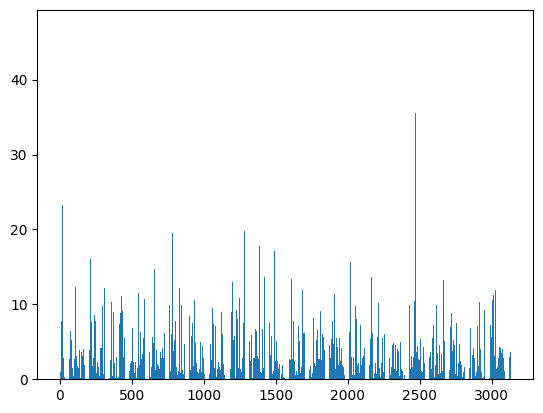

In [20]:
import math
test_set = test_set.to(dtype=torch.float32, device=device)
test_labels = test_labels.to(dtype=torch.float32, device=device) 
outcome = model(test_set)

print(outcome, test_labels)
#import pdb; pdb.set_trace()

x = np.array( list(range(0, len(outcome))) )
y= torch.abs(outcome.squeeze(1)-test_labels).detach().cpu().numpy()

import matplotlib.pyplot as plt

plt.bar( x, y )


In [21]:
print(outcome.squeeze(1)[1000:1300])
print(test_labels[1000:1300])

tensor([42.9882, 49.3449, 50.0287, 39.9450, 49.2693, 49.1995, 47.3083, 47.2205,
        49.7279, 49.7846, 47.1563, 50.9051, 46.9996, 43.9680, 50.1809, 47.0593,
        44.2203, 45.9346, 47.4580, 34.3672, 47.6068, 47.4438, 70.2374, 49.7282,
        50.5858, 45.5321, 51.6298, 42.7209, 49.0641, 43.7813, 40.9183, 40.7916,
        43.9736, 39.0630, 41.5210, 43.7665, 41.1340, 48.5620, 45.7120, 48.3101,
        44.8511, 45.7405, 44.7014, 44.5106, 44.5495, 40.2479, 42.9106, 42.8470,
        44.1678, 42.5588, 44.8556, 46.6642, 43.6719, 45.8795, 45.0223, 54.7563,
        47.0398, 44.9147, 46.3133, 45.3302, 46.3564, 46.8327, 47.3143, 49.2041,
        41.5133, 48.5097, 43.0319, 43.2416, 44.5991, 42.8804, 43.6086, 47.5555,
        48.9399, 42.3704, 40.8704, 43.7193, 45.6005, 44.6644, 44.8922, 39.9625,
        42.0870, 43.9282, 36.2410, 40.0657, 40.7622, 39.0957, 45.3102, 41.3031,
        46.8928, 41.0726, 41.8192, 46.3767, 42.6554, 50.4990, 47.9974, 45.1538,
        45.4410, 44.0063, 47.1872, 38.79

In [22]:
loss_test = loss(outcome, test_labels.unsqueeze(-1))
print('MSE: ' + str(loss_test))
print('RMSE: ' + str(torch.sqrt(loss_test)))

MSE: tensor(37.8814, device='cuda:0', grad_fn=<MseLossBackward0>)
RMSE: tensor(6.1548, device='cuda:0', grad_fn=<SqrtBackward0>)


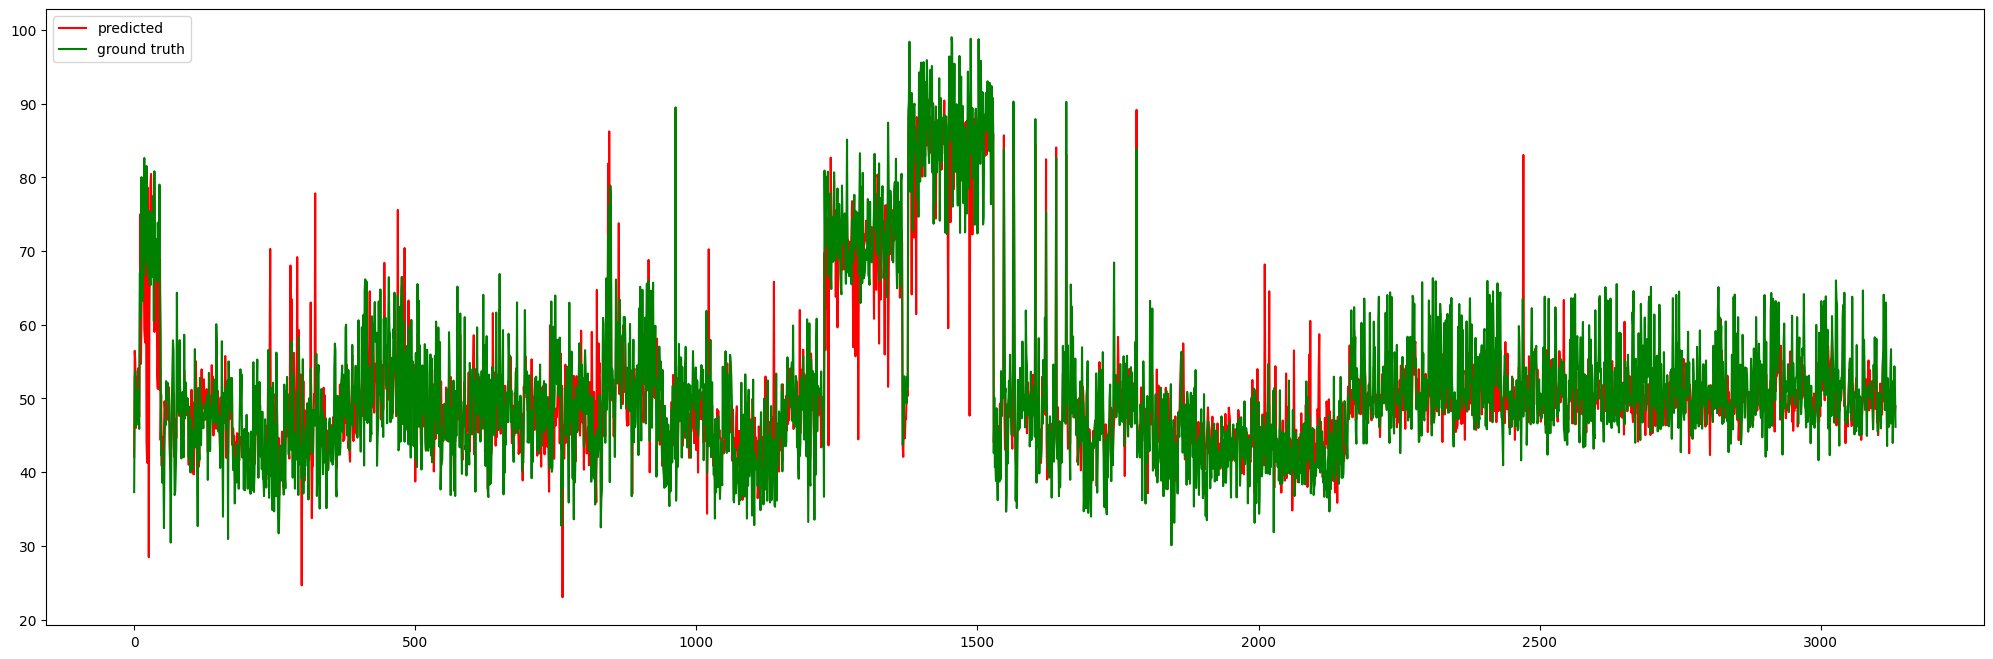

In [32]:
indexes = list(range(0,len(test_labels) ) ) 

plt.figure(figsize=(25,8))
plt.plot(indexes, outcome.flatten().detach().cpu().tolist(), c='red', label="predicted")
plt.plot( indexes, test_labels.detach().cpu().tolist(), c='green', label="ground truth")
plt.legend(loc="upper left")
#plt.ylim(-1.5, 2.0)
plt.show()

In [ ]:



'''sequence_Example = "A E T C Z A O"
sequence_Example = re.sub(r"[UZOB]", "X", sequence_Example)
encoded_input = tokenizer(sequence_Example, return_tensors='pt')
output = model(**encoded_input)
print(output)'''